In [1]:
import pandas as pd
import numpy as np
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [4]:
data = pd.read_excel('oil_data_for_tree.xlsx')
data.head()

,uid,oil_actv_dt,create_dt,total_oil_cnt,pay_amount_total,class_new,bad_ind,oil_amount,discount_amount,sale_amount,amount,pay_amount,coupon_amount,payment_coupon_amount,channel_code,oil_code,scene,source_app,call_source
0,A8217710,2018-08-19,2018-08-17,275.0,48295495.4,B,0,3308.56,1760081.0,1796001.0,1731081.0,8655401.0,1.0,1.0,1,3,2,0,3
1,A8217710,2018-08-19,2018-08-16,275.0,48295495.4,B,0,4674.68,2487045.0,2537801.0,2437845.0,12189221.0,1.0,1.0,1,3,2,0,3
2,A8217710,2018-08-19,2018-08-15,275.0,48295495.4,B,0,1873.06,977845.0,997801.0,961845.0,4809221.0,1.0,1.0,1,2,2,0,3
3,A8217710,2018-08-19,2018-08-14,275.0,48295495.4,B,0,4837.78,2526441.0,2578001.0,2484441.0,12422201.0,1.0,1.0,1,2,2,0,3
4,A8217710,2018-08-19,2018-08-13,275.0,48295495.4,B,0,2586.38,1350441.0,1378001.0,1328441.0,6642201.0,1.0,1.0,1,2,2,0,3


In [5]:
set(data.class_new)

{'A', 'B', 'C', 'D', 'E', 'F'}

org_lst 不需要做特殊变换，直接去重  
agg_lst 数值型变量做聚合  
dstc_lst 文本型变量做cnt  

In [7]:
org_lst = ['uid','create_dt','oil_actv_dt','class_new','bad_ind']
agg_lst = ['oil_amount','discount_amount','sale_amount','amount','pay_amount','coupon_amount','payment_coupon_amount']
dstc_lst = ['channel_code','oil_code','scene','source_app','call_source']

数据重组

In [8]:
df = data[org_lst].copy()
df[agg_lst] = data[agg_lst].copy()
df[dstc_lst] = data[dstc_lst].copy()

看一下缺失情况

In [9]:
df.isna().sum()

uid                         0
create_dt                4944
oil_actv_dt                 0
class_new                   0
bad_ind                     0
oil_amount               4944
discount_amount          4944
sale_amount              4944
amount                   4944
pay_amount               4944
coupon_amount            4944
payment_coupon_amount    4946
channel_code                0
oil_code                    0
scene                       0
source_app                  0
call_source                 0
dtype: int64

看一下基础变量的describe

In [10]:
df.describe()

,bad_ind,oil_amount,discount_amount,sale_amount,amount,pay_amount,coupon_amount,payment_coupon_amount,channel_code,oil_code,scene,source_app,call_source
count,50609.000000,45665.000000,4.566500e+04,4.566500e+04,4.566500e+04,4.566500e+04,45665.000000,45663.000000,50609.000000,50609.000000,50609.000000,50609.000000,50609.000000
mean,0.017764,425.376107,1.832017e+05,1.881283e+05,1.808673e+05,9.043344e+05,0.576853,149.395397,1.476378,1.617894,1.906519,0.306072,2.900729
std,0.132093,400.596244,2.007574e+05,2.048742e+05,1.977035e+05,9.885168e+05,0.494064,605.138823,1.511470,3.074166,0.367280,0.893682,0.726231
min,0.000000,1.000000,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,175.440000,6.039100e+04,6.200100e+04,5.976100e+04,2.988010e+05,0.000000,1.000000,1.000000,0.000000,2.000000,0.000000,3.000000
50%,0.000000,336.160000,1.229310e+05,1.279240e+05,1.209610e+05,6.048010e+05,1.000000,1.000000,1.000000,0.000000,2.000000,0.000000,3.000000
75%,0.000000,557.600000,2.399050e+05,2.454010e+05,2.360790e+05,1.180391e+06,1.000000,100.000000,1.000000,0.000000,2.000000,0.000000,3.000000
max,1.000000,7952.820000,3.916081e+06,3.996001e+06,3.851081e+06,1.925540e+07,1.000000,50000.000000,6.000000,9.000000,2.000000,3.000000,4.000000


对creat_dt做补全，用oil_actv_dt来填补，并且截取6个月的数据。  
构造变量的时候不能直接对历史所有数据做累加。  
否则随着时间推移，变量分布会有很大的变化。

In [11]:
def time_isna(x,y):
    if str(x) == 'NaT':
        x = y
    else:
        x = x
    return x
df2 = df.sort_values(['uid','create_dt'],ascending = False)
df2['create_dt'] = df2.apply(lambda x: time_isna(x.create_dt,x.oil_actv_dt),axis = 1)
df2['dtn'] = (df2.oil_actv_dt - df2.create_dt).apply(lambda x :x.days)
df = df2[df2['dtn']<180]
df.head()

,uid,create_dt,oil_actv_dt,class_new,bad_ind,oil_amount,discount_amount,sale_amount,amount,pay_amount,coupon_amount,payment_coupon_amount,channel_code,oil_code,scene,source_app,call_source,dtn
50608,B96436391985035703,2018-10-08,2018-10-08,B,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0
50607,B96436391984693397,2018-10-11,2018-10-11,E,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0
50606,B96436391977217468,2018-10-17,2018-10-17,B,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0
50605,B96436391976480892,2018-09-28,2018-09-28,B,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0
50604,B96436391972106043,2018-10-19,2018-10-19,A,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0


对org_list变量求历史贷款天数的最大间隔，并且去重

In [13]:
base = df[org_lst]
base['dtn'] = df['dtn']
base = base.sort_values(['uid','create_dt'],ascending = False)
base = base.drop_duplicates(['uid'],keep = 'first')
base.shape

<ipython-input-13-0389fbf74835>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['dtn'] = df['dtn']


(11099, 6)

做变量衍生

In [14]:
gn = pd.DataFrame()
for i in agg_lst:
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:len(df[i])).reset_index())
    tp.columns = ['uid',i + '_cnt']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.where(df[i]>0,1,0).sum()).reset_index())
    tp.columns = ['uid',i + '_num']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nansum(df[i])).reset_index())
    tp.columns = ['uid',i + '_tot']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmean(df[i])).reset_index())
    tp.columns = ['uid',i + '_avg']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmax(df[i])).reset_index())
    tp.columns = ['uid',i + '_max']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmin(df[i])).reset_index())
    tp.columns = ['uid',i + '_min']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanvar(df[i])).reset_index())
    tp.columns = ['uid',i + '_var']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmax(df[i]) -np.nanmin(df[i]) ).reset_index())
    tp.columns = ['uid',i + '_var']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmean(df[i])/max(np.nanvar(df[i]),1)).reset_index())
    tp.columns = ['uid',i + '_var']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')

<ipython-input-14-a2884ff489a7>:21: RuntimeWarning: Mean of empty slice
  tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmean(df[i])).reset_index())
<ipython-input-14-a2884ff489a7>:27: RuntimeWarning: All-NaN axis encountered
  tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmax(df[i])).reset_index())
<ipython-input-14-a2884ff489a7>:33: RuntimeWarning: All-NaN axis encountered
  tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmin(df[i])).reset_index())
<ipython-input-14-a2884ff489a7>:39: RuntimeWarning: Degrees of freedom <= 0 for slice.
  tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanvar(df[i])).reset_index())
<ipython-input-14-a2884ff489a7>:45: RuntimeWarning: All-NaN axis encountered
  tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmax(df[i]) -np.nanmin(df[i]) ).reset_index())
<ipython-input-14-a2884ff489a7>:51: RuntimeWarning: Mean of empty slice
  tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmean(df[i])/max(np.nanv

对dstc_lst变量求distinct个数

In [15]:
gc = pd.DataFrame()
for i in dstc_lst:
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df: len(set(df[i]))).reset_index())
    tp.columns = ['uid',i + '_dstc']
    if gc.empty == True:
        gc = tp
    else:
        gc = pd.merge(gc,tp,on = 'uid',how = 'left')

将变量组合在一起

In [16]:
fn = pd.merge(base,gn,on= 'uid')
fn = pd.merge(fn,gc,on= 'uid') 
fn.shape

(11099, 74)

In [17]:
fn = fn.fillna(0)

In [18]:
fn.head(100)

,uid,create_dt,oil_actv_dt,class_new,bad_ind,dtn,oil_amount_cnt,oil_amount_num,oil_amount_tot,oil_amount_avg,...,payment_coupon_amount_max,payment_coupon_amount_min,payment_coupon_amount_var_x,payment_coupon_amount_var_y,payment_coupon_amount_var,channel_code_dstc,oil_code_dstc,scene_dstc,source_app_dstc,call_source_dstc
0,B96436391985035703,2018-10-08,2018-10-08,B,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
1,B96436391984693397,2018-10-11,2018-10-11,E,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
2,B96436391977217468,2018-10-17,2018-10-17,B,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
3,B96436391976480892,2018-09-28,2018-09-28,B,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
4,B96436391972106043,2018-10-19,2018-10-19,A,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,B96117370332355190,2018-10-19,2018-10-19,B,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
96,B96117370330101658,2018-10-12,2018-10-12,B,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
97,B96117370330066347,2018-10-01,2018-10-01,D,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
98,B96117370328724350,2018-09-20,2018-09-20,C,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1


训练决策树模型

In [19]:
x = fn.drop(['uid','oil_actv_dt','create_dt','bad_ind','class_new'],axis = 1)
y = fn.bad_ind.copy()
from sklearn import tree

dtree = tree.DecisionTreeRegressor(max_depth = 2,min_samples_leaf = 500,min_samples_split = 5000)
dtree = dtree.fit(x,y)

In [21]:
pip install pydotplus

     |████████████████████████████████| 278 kB 1.7 MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24567 sha256=4d043c9903a9249ebb8790f1ef92c0bd0303a53d3af7b1722fa4a4959575d71b
  Stored in directory: /Users/dantan/Library/Caches/pip/wheels/fe/cd/78/a7e873cc049759194f8271f780640cf96b35e5a48bef0e2f36
Successfully built pydotplus
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#brew install graphviz

输出决策树图像，并作出决策

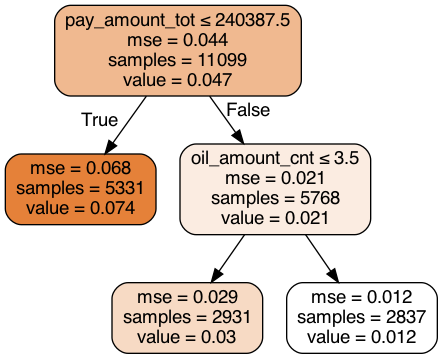

In [26]:
import pydotplus 
from IPython.display import Image
from six import StringIO
#from sklearn.externals.six import StringIO
import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
with open("dt.dot", "w") as f:
    tree.export_graphviz(dtree, out_file=f)
dot_data = StringIO()
tree.export_graphviz(dtree, out_file=dot_data,
                         feature_names=x.columns,
                         class_names=['bad_ind'],
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

value = badrate

In [53]:
sum(fn.bad_ind)/len(fn.bad_ind)

0.04658077304261645